In [6]:
#1D DFO Fixed Accuracy
import numpy as np
import scipy.optimize as op
import dfols as dfo
import matplotlib.pyplot as plt

class DFO_FISTA:
    def __init__(self, A, b, y, x0, L, mu, alpha,nu, xi, max_iter=3000, tol=1e-12):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        #self.x0 = np.squeeze(np.asarray(x0))
        self.x0 = np.zeros((np.shape(b)[0],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.L = L
        self.mu = mu
        self.nu = nu
        self.xi = xi
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.upperVal = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.uppersolver = dfo.DFO()
    
    def FISTA(self, alpha,nu,xi,i):
        # Algorithm for solving the lower-level problem
        x = self.x0[i,:]
        t = 0
        normgrad = 2
        for k in range(self.max_iter):
            x_old = x
            self.L = 1+ (np.exp(alpha)/np.exp(nu))* normgrad**2+np.exp(xi)
            self.mu = 1+np.exp(xi)
            tau = 1/self.L
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, alpha, nu, xi,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                print("i = "+ str(i)+ " Converged at iteration: " + str(k+1))
                self.lowerIterSum += k+1
                return self.x0[i,:]
            x = z -  tau*p
            self.x0[i,:] = x
            self.lowerIterSum += self.max_iter
        return x
    def DFO(self):
        #solver = dfo.DFO()
        #theta0 = np.array([self.alpha, self.nu, self.xi])
        soln = self.uppersolver.solve(self.UpperLevel, np.array([self.alpha, self.nu, self.xi]),bounds=(-10*np.ones(3),7*np.ones(3)),rhoend=1e-8,print_progress=True,maxfun=300)
        return soln
    def phi(self, x, alpha,nu,xi, i):
        return 0.5*np.linalg.norm(x-self.y[i,:])**2 +np.exp(alpha) * self.TV(x, np.exp(nu)) + 0.5 *np.exp(xi) * np.linalg.norm(x)**2
    def TV(self,x, nu):
        gradx = x[1:]-x[:-1]
        return (np.sum(np.sqrt(np.abs(gradx)**2+ nu**2)))
    def gradTV(self,x, nu):
        grad = np.zeros(len(x))
        grad[:-1]+= -(x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        grad[1:] += (x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)

        #Green 
        # grad[:-1]+= np.tanh(-(x[1:]-x[:-1])/nu)
        # grad[1:] += np.tanh((x[1:]-x[:-1])/nu)
        
        return np.squeeze(np.asarray(grad))
    def gradPhi(self, x, alpha,nu,xi,i):
        return np.squeeze(np.asarray(x - np.squeeze(np.asarray(self.y[i,:])) + np.exp(alpha) *self.gradTV(x, np.exp(nu)) + np.exp(xi) * x))
    
    def UpperLevel(self,theta):
        alpha = theta[0]
        nu = theta[1]
        xi = theta[2]
        # FISTA
        if 1:
            UL = []
            for i in range(np.shape(self.b)[0]):
                UL.append(np.linalg.norm(self.FISTA(alpha,nu,xi,i)- np.squeeze(np.asarray(self.b[i,:]))))
            if self.uppersolver.funVal==0:
                self.upperVal.append(np.sum(UL))
            else:
                self.upperVal.append(self.uppersolver.funVal)
            self.lowerIter.append(self.lowerIterSum)
        if 0:        
        #LBFGS
            UL = []
            for i in range(np.shape(self.b)[0]):
                UL.append(np.linalg.norm(self.LBFGS(alpha,nu,xi,i)- np.squeeze(np.asarray(self.b[i,:]))))
        
        return np.squeeze(np.array([UL]))
    def LBFGS(self,alpha,nu,xi,i):
        # op.fmin_l_bfgs_b(self.phi, self.gradPhi, x0=self.x0, args=(i,theta))
        self.x0 = op.minimize(self.phi, self.x0, args=(alpha,nu,xi,i), method='L-BFGS-B', jac=self.gradPhi,tol=1e-14).x
        return np.squeeze(np.asarray(self.x0))


Initialise DFO
i = 0 Converged at iteration: 455
i = 1 Converged at iteration: 456
i = 2 Converged at iteration: 456
i = 3 Converged at iteration: 456
i = 4 Converged at iteration: 457
i = 0 Converged at iteration: 404
i = 1 Converged at iteration: 416
i = 2 Converged at iteration: 416
i = 3 Converged at iteration: 417
i = 4 Converged at iteration: 416
i = 0 Converged at iteration: 227
i = 1 Converged at iteration: 233
i = 2 Converged at iteration: 233
i = 3 Converged at iteration: 234
i = 4 Converged at iteration: 234
i = 0 Converged at iteration: 346
i = 1 Converged at iteration: 336
i = 2 Converged at iteration: 344
i = 3 Converged at iteration: 341
i = 4 Converged at iteration: 341
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1    3.82e+00  4.01e+00  3.00e-01  3.00e-01    4   
i = 0 Converged at iteration: 374
i = 1 Converged at iteration: 364
i = 2 Converged at iteration: 373
i = 3 Converged at iteration: 369
i = 4 Converged at iteration: 369
  1     2    3.

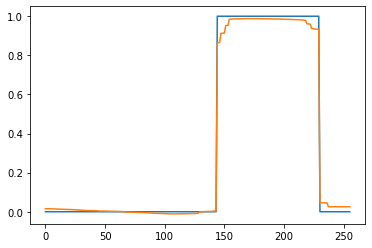

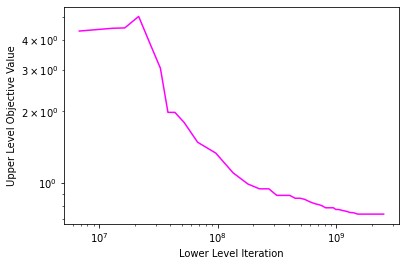

In [7]:
#Denoising 1D
x0 = np.random.rand(1,256)
data = np.load('1dData.npz')
b = data['X']
b = b[:5,:]
A = np.eye(x0.shape[1])
y = data['y']
y = y[:5,:]
#theta = [nu, xi, alpha] = [1e-3,1e-3,1e-3]
Bilevel = DFO_FISTA(A, b, y, x0, 1, 1.3, -1, -3, -3)
# for l in np.linspace(1,10,100):
#     Bilevel = DFO_FISTA(A, b, y, x0, l, 1.3, 0, -5, -1)
#     print (str(l) + ': ' + str(Bilevel.FISTA(0, -5, -1,0)))
result = Bilevel.DFO()
thetaOptimal = result.x
print(thetaOptimal)
denoised = Bilevel.FISTA(thetaOptimal[0],thetaOptimal[1],thetaOptimal[2],1)
plt.plot(b[1,:])
plt.plot(denoised)
plt.show()

plt.plot(Bilevel.lowerIter,Bilevel.upperVal,color='magenta')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')


In [137]:
#Renaming images
import os
path = '/Users/sadegh/Downloads/Humans/'
files = os.listdir(path)


for index, file in enumerate(files):
    os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(index), '.jpg'])))

In [ ]:
#Croping images
from PIL import Image
path = '/Users/sadegh/Downloads/Humans/'
new_width = 512
new_height = 512
for i in range(188):
    im = Image.open(path + '/' + str(i) + '.jpg')
    width, height = im.size   # Get dimensions

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    im.save(path+ '/croped' + '/' + str(i) + '.png', 'PNG')

In [57]:
#Gray scaling & Resizing images
from PIL import Image
import cv2
path = '/Users/sadegh/Downloads/Humans'

for i in range(300):
    im = Image.open(path + '/' + str(i) + '.jpg')
    im = im.convert('L')
    im = im.resize((256,256))
    im.save(path+ '/256*256' + '/' + str(i) + '.png', 'PNG')

    

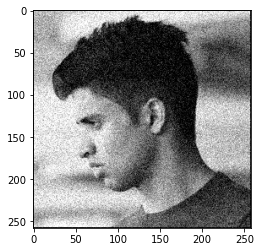

In [64]:
# Making a dataset 2D images
import matplotlib.pyplot as plt
import numpy as np
path = '/Users/sadegh/Downloads/Humans/256*256'

X = np.zeros((300,66564))
extended = np.zeros((258,258))
for i in range(300):
    im = Image.open(path + '/' + str(i) + '.png')
    data = np.asarray(im)
    extended[1:-1,1:-1] = data
    data = np.array(extended.flatten())
    #print(np.shape(data))
    X[i,:] = data

#print(np.shape(X))
np.savez(path+ '/' +'Data.npz', X=X)

data = np.load(path+ '/' +'Data.npz')
X = data['X']
X= X/255

for i in range(1,X.shape[0]-1):
    for j in range(1,X.shape[1]-1):
        Noise = np.random.normal(0,0.1,1)
        #noise = np.random.normal(0, 0.1, 1)
        if X[i,j] + Noise > 1:
            X[i,j] = 1
        elif X[i,j] + Noise < 0:
            X[i,j] = 0
        else:
            X[i,j] = X[i,j] + Noise
Noisy = X*255

np.savez(path+ '/' +'DataNoisy2.npz', y=Noisy)
sample= Noisy[10,:]
sample = sample.reshape(258,258)
sample = Image.fromarray(sample)
plt.imshow(sample)
plt.show()




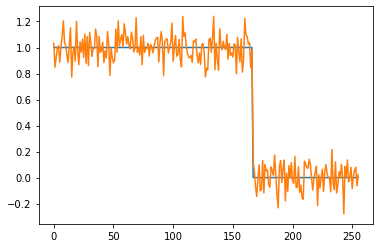

In [163]:
#1D image generating
N = 256
X = np.zeros((100,N))
for i in range(100):
    c = N/4 +np.random.rand(1)*3*N/4
    r = N/8 +np.random.rand(1)*N/4
    for j in range(N):
        if np.abs(j-c)< r:
            X[i,j] = 1
        else:
            X[i,j] = 0
NoisyData = np.zeros((100,N))
for i in range(100):
    NoisyData[i,:] = X[i,:] + np.random.normal(0,0.1,N)   
plt.plot(X[0,:])
plt.plot(NoisyData[0,:])

np.savez('1dData.npz', X=X, y=NoisyData)


i = 0 Converged at iteration: 1698
i = 1 Converged at iteration: 1759
i = 2 Converged at iteration: 1736
i = 3 Converged at iteration: 1780
i = 4 Converged at iteration: 1739
i = 5 Converged at iteration: 1779
i = 6 Converged at iteration: 1773
i = 7 Converged at iteration: 1735
i = 8 Converged at iteration: 1749
i = 9 Converged at iteration: 1760
i = 0 Converged at iteration: 1867
i = 1 Converged at iteration: 2052
i = 2 Converged at iteration: 1931
i = 3 Converged at iteration: 1966
i = 4 Converged at iteration: 1995
i = 5 Converged at iteration: 1899
i = 6 Converged at iteration: 1972
i = 7 Converged at iteration: 1931
i = 8 Converged at iteration: 1979
i = 9 Converged at iteration: 2010
i = 0 Converged at iteration: 714
i = 1 Converged at iteration: 778
i = 2 Converged at iteration: 733
i = 3 Converged at iteration: 739
i = 4 Converged at iteration: 751
i = 5 Converged at iteration: 725
i = 6 Converged at iteration: 744
i = 7 Converged at iteration: 732
i = 8 Converged at iteration

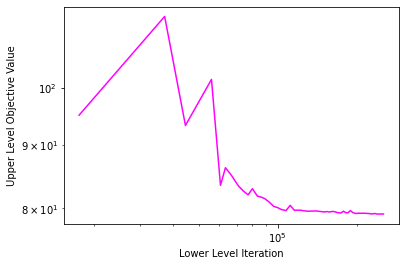

In [1]:
#2D TV
#Denoising
from functools import partial
from optparse import Option
import numpy as np
import scipy.optimize as op
import dfols as dfo
from PIL import Image
import matplotlib.pyplot as plt

class DFO_FISTA:
    def __init__(self, A, b, y, x0, L, mu, alpha,nu, xi, max_iter=3000, tol=1e-6):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        self.x0 = np.zeros((np.shape(b)[2],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.L = L
        self.mu = mu
        self.nu = nu
        self.xi = xi
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.gtol = 0
        self.matsize = np.shape(x0)
        self.upperVal = []
        self.lowerIter = []
        self.lowerIterSum = 0
    def FISTA(self, alpha,nu,xi,i):
        # Algorithm for solving the lower-level problem
        x = self.x0[i,:]
        t = 0
        for k in range(self.max_iter):
            x_old = x
            partial_x = 0
            x = np.reshape(x,(256,256))
            #partial_x += np.linalg.norm(x[:,1:]-x[:,:-1])+np.linalg.norm(x[1:,:]-x[:-1,:])
            x = x.flatten()
            self.L = 1+ (np.exp(alpha)/np.exp(nu))* 8+np.exp(xi)
            self.mu = 1+np.exp(xi)
            tau = 1/(self.L)
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, alpha, nu, xi,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                print("i = "+ str(i)+ " Converged at iteration: " + str(k+1))
                self.lowerIterSum += k+1
                return self.x0[i,:]
            x = z -  tau*p
        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        return x

    def DFO(self):
        #theta0 = np.array([self.alpha, self.nu, self.xi])
        user_params = {'logging.save_diagnostic_info': True}
        user_params['logging.save_xk'] = True
        # Save diagnostic info to CSV
        soln = dfo.solve(self.UpperLevel, np.array([self.alpha, self.nu, self.xi]),bounds=(-7*np.ones(3),7*np.ones(3)),rhoend=1e-8,print_progress=True,maxfun=150,user_params=user_params)
        soln.diagnostic_info.to_csv('DFOdetail.csv')

        return soln
    def phi(self, x, alpha,nu,xi, i):
        phi = 0.5*np.linalg.norm(x.flatten()-self.y[:,:,i].flatten())**2 +np.exp(alpha) * self.TV2D(x, np.exp(nu)) + 0.5 *np.exp(xi) * np.linalg.norm(x)**2
        return phi
    def TV(self,x, nu):
        return (np.sum(np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)))
    def TV2D(self,x, nu):
        x = np.reshape(x,(256,256))
        tv = 0
        tv += (np.sum(np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)))
        tv += (np.sum(np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)))
        return tv
    
    def gradTV2D(self,x, nu):

        x = np.reshape(x,(self.matsize[0],self.matsize[1]))

        grad = np.zeros(np.shape(x))
        grad[:,:-1]+= -(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        grad[:,1:] += (x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
          
        grad[:-1,:]+= -(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        grad[1:,:] += (x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)             
        return grad.flatten()
    
    def gradTV(self,x, nu):
        grad = np.zeros(len(x))
        grad[:-1]+= -(x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        grad[1:] += (x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        
        return np.squeeze(np.asarray(grad))
    def gradPhi(self, x, alpha,nu,xi,i):
        x = np.reshape(x,self.matsize)
        gradPhi = np.squeeze(np.asarray(x.flatten() - np.squeeze(np.asarray(self.y[:,:,i].flatten())) + np.exp(alpha) *self.gradTV2D(x, np.exp(nu)) + np.exp(xi) * x.flatten()))
        return gradPhi.flatten()
    
    def UpperLevel(self,theta):
        alpha = theta[0]
        nu = theta[1]
        xi = theta[2]
        # FISTA
        UL = []
        for i in range(np.shape(self.b)[2]):
            UL.append(np.linalg.norm(self.FISTA(alpha,nu,xi,i)- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        self.upperVal.append(np.sum(UL))
        self.lowerIter.append(self.lowerIterSum)
        #LBFGS
        # UL = []
        # for i in range(np.shape(self.b)[2]):
        #     UL.append(np.linalg.norm(self.LBFGS(alpha,nu,xi,i).flatten()- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        
        return np.squeeze(np.array([UL]))
    def LBFGS(self,alpha,nu,xi,i):
        x0 = self.x0.flatten()
        # op.fmin_l_bfgs_b(self.phi, self.gradPhi, x0=self.x0, args=(i,theta))
        self.x0 = op.minimize(self.phi, x0, args=(alpha,nu,xi,i), method='L-BFGS-B', jac=self.gradPhi,options={'disp': None, 'gtol': int(np.sqrt(len(x0)))*1e-06/(1+np.exp(xi))**2},tol= 1e-8).x
        self.gtol = 0
        return np.squeeze(np.asarray(self.x0))
    
    


path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:10]
x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
y = y[:,:,0:10]

Bilevel = DFO_FISTA(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
result = Bilevel.DFO()
thetaOptimal = result.x
print("Theta:" +str(thetaOptimal))

plt.plot(Bilevel.lowerIter,Bilevel.upperVal,color='magenta')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')
#[-2.62850676 -5.68326658 -4.82007257]



i = 16 Converged at iteration: 1111


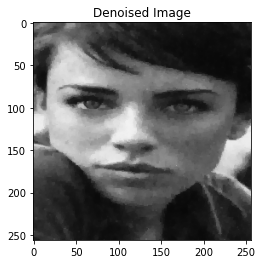

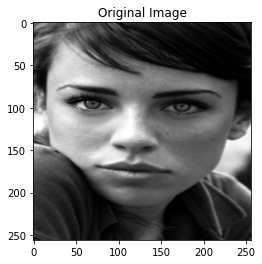

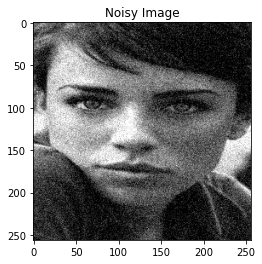

In [28]:

path = '/Users/sadegh/Downloads/Humans/256*256'
#np.random.seed(0)
#Previous calculation on colab [-2.62850676 ,-5.68326658 ,-4.82007257]
#thetaOptimal = [-2.62927107, -4.76697469, -5.71802461]


data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:50]
x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
y = y[:,:,0:50]
Bilevel = DFO_FISTA(A, b, y, x0, 2, 1+1e-3, thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],max_iter=10000)
#im = Bilevel.FISTA(thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],7)
im = Bilevel.FISTA(thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],16)*255
sample = im.reshape(256,256)
sample = Image.fromarray(sample)
plt.imshow(sample)
plt.title("Denoised Image")
plt.show()

# im = Bilevel.FISTA(-2.616204 ,  -4.7507457  ,-5.71675456,23)*255
# sample = im.reshape(256,256)
# sample = Image.fromarray(sample)
# plt.imshow(sample)
# plt.title("Denoised Image Previous")
# plt.show()

original = b[:,:,16]
original = original.reshape(256,256)*255
original = Image.fromarray(original)
plt.imshow(original)
plt.title("Original Image")
plt.show()

NImage = y[:,:,16]
NImage = NImage.reshape(256,256)*255
NImage = Image.fromarray(NImage)
plt.imshow(NImage)
plt.title("Noisy Image")
plt.show()


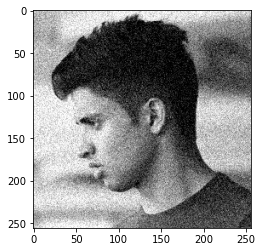

In [112]:
# Making a dataset of 2D images
import matplotlib.pyplot as plt
import numpy as np
path = '/Users/sadegh/Downloads/Humans/256*256'

X = np.zeros((256,256,50))
for i in range(50):
    im = Image.open(path + '/' + str(i) + '.png')
    data = np.asarray(im)
    X[:,:,i] = data

np.savez(path+ '/' +'Data.npz', X=X)

data = np.load(path+ '/' +'Data.npz')
X = data['X']
X= X/255
for k in range(np.shape(X)[2]):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Noise = np.random.normal(0,0.1,1)
            if X[i,j,k] + Noise > 1:
                X[i,j,k] = 1
            elif X[i,j,k] + Noise < 0:
                X[i,j,k] = 0
            else:
                X[i,j,k] = X[i,j,k] + Noise
Noisy = X*255

np.savez(path+ '/' +'DataNoisy2.npz', y=Noisy)
sample= Noisy[:,:,10]
sample = sample.reshape(256,256)
sample = Image.fromarray(sample)
plt.imshow(sample)
plt.show()




In [120]:
#HOAG Algorithm
# Adaptive Step Size
import scipy.sparse as sp
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as cg


class HOAG:
    def __init__(self, A, b, y, x0, L, mu, alpha,nu, xi, max_iter=2000, tol=1e-1, lowersolver='FISTA'):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        self.matsize = np.shape(x0)
        self.x0 = np.zeros((np.shape(b)[2],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.L = L
        self.mu = mu
        self.nu = nu
        self.xi = xi
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.gtol = 0
        self.upperObjective = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.lowersolver = lowersolver
        self.success = False
        self.upperObjectivePrint = []
    def FISTA(self, alpha,nu,xi,i,epsilon):
        # Algorithm for solving the lower-level problem
        self.tol= epsilon
        x = self.x0[i,:]
        t = 0
        for k in range(self.max_iter):
            x_old = x
            x = np.reshape(x,(256,256))
            x = x.flatten()
            self.L = 1+ (np.exp(alpha)/np.exp(nu))* 8+np.exp(xi)
            self.mu = 1+np.exp(xi)
            tau = 1/(self.L)
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, alpha, nu, xi,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                self.lowerIterSum += k+1
                return self.x0[i,:]
            x = z -  tau*p

        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        return self.x0[i,:]
    def phi(self, x, alpha,nu,xi, i):
        phi = 0.5*np.linalg.norm(x.flatten()-self.y[:,:,i].flatten())**2 +np.exp(alpha) * self.TV2D(x, np.exp(nu)) + 0.5 *np.exp(xi) * np.linalg.norm(x)**2
        return phi
    def gradPhi(self, x, alpha,nu,xi,i):
        x = np.reshape(x,self.matsize)
        gradPhi = np.squeeze(np.asarray(x.flatten() - np.squeeze(np.asarray(self.y[:,:,i].flatten())) + np.exp(alpha) *self.gradTV2D(x, np.exp(nu)) + np.exp(xi) * x.flatten()))
        return gradPhi.flatten()
    def hessianPhi(self, x, alpha,nu,xi,i,d):
        x = np.reshape(x,self.matsize)
        d = np.reshape(d,self.matsize)
        hess = (1+np.exp(xi))*d + np.exp(alpha) * self.hessianTV2D(x, np.exp(nu),d) 
        return hess
    def TV(self,x, nu):
        return (np.sum(np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)))
    def TV2D(self,x, nu):
        x = np.reshape(x,(256,256))
        tv = 0
        tv += (np.sum(np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)))
        tv += (np.sum(np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)))
        return tv
    
    def gradTV2D(self,x, nu):

        x = np.reshape(x,(self.matsize[0],self.matsize[1]))

        grad = np.zeros(np.shape(x))
        grad[:,:-1]+= -(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        grad[:,1:] += (x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
          
        grad[:-1,:]+= -(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        grad[1:,:] += (x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)             
        return grad.flatten()
    def hessianTV2D(self,x, nu,d):
        hess = np.zeros(self.matsize)
        left = np.zeros(self.matsize)
        right = np.zeros(self.matsize)
        up = np.zeros(self.matsize)
        down = np.zeros(self.matsize)

        #Matrix-vector version
        down[:,:-1] = 1-(x[:,1:]-x[:,:-1])**2/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        hess[:,:-1] += np.multiply(-down[:,:-1] , d[:,:-1])
        up[:,1:] = 1-(x[:,1:]-x[:,:-1])**2/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
        hess[:,1:] += np.multiply(-up[:,1:] , d[:,1:])
        right[:-1,:] = 1-(x[1:,:]-x[:-1,:])**2/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        hess[:-1,:]+= np.multiply(-right[:-1,:] , d[:-1,:])
        left[1:,:] = 1-(x[1:,:]-x[:-1,:])**2/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        hess[1:,:] += np.multiply(-left[1:,:] , d[1:,:])
        hess += np.multiply(d , (left + right + up + down))
        
        return hess
    def gradTV(self,x, nu):
        grad = np.zeros(len(x))
        grad[:-1]+= -(x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        grad[1:] += (x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        
        return np.squeeze(np.asarray(grad))    
    def partialNuGradTV(self,x, nu):
        x = np.reshape(x,(self.matsize[0],self.matsize[1]))
        grad = np.zeros(np.shape(x))
        grad[:,:-1]+= nu *(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        grad[:,1:] += -nu*(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
          
        grad[:-1,:]+= nu*(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        grad[1:,:] += -nu*(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)             
        return grad 

    def CG(self,alpha,nu,xi,i,x,b,tol):
        r = b-self.hessianPhi(x,alpha,nu,xi,i,np.zeros(np.shape(x))).flatten()
        p = r.copy()
        rsold = np.linalg.norm(r)**2
        solution = np.zeros(np.shape(x))
 
        while np.linalg.norm(r)>tol:
            Ap = self.hessianPhi(x,alpha,nu,xi,i,p).flatten()
            alpha = rsold/np.dot(p.T,Ap)
            solution = solution + alpha*p
            r = r - alpha*Ap
            rsnew = np.linalg.norm(r)**2
            if np.sqrt(rsnew) < tol:
                return solution
            p = r + (rsnew/rsold)*p
            rsold = rsnew.copy()
        return solution
    def CG_scipy(self,alpha,nu,xi,i,x,b,tol):
        mv = lambda v: self.hessianPhi(x,alpha,nu,xi,i,v)
        A = LinearOperator((self.matsize[0]**2,self.matsize[1]**2), matvec=mv)
        return np.array(cg(A, b, tol = tol)[0])
    def LBFGS(self,alpha,nu,xi,i):
        x0 = self.x0.flatten()
        self.x0 = op.minimize(self.phi, x0, args=(alpha,nu,xi,i), method='L-BFGS-B', jac=self.gradPhi,options={'disp': None, 'gtol': int(np.sqrt(len(x0)))*1e-06/(1+np.exp(xi))**2},tol= 1e-8).x
        self.gtol = 0
        return np.squeeze(np.asarray(self.x0))
    def project(self,theta):
        for i in range(len(theta)):
            if theta[i] < -10:
                theta[i] = -10
            elif theta[i] > 10:
                theta[i] = 10
        return theta
        

    def solver(self):
        epsilon = 1e-1
        rho = 0.9
        inner = []
        q = []
        p = []
        self.theta = [self.alpha,self.nu,self.xi]
        C = 0.25
        factor_L_theta = 1.0
        L = 1
        for k in range(150):
            upperObjectiveTemp = []
            for i in range(np.shape(self.b)[2]):
                inner.append(self.FISTA(self.theta[0],self.theta[1],self.theta[2],i,epsilon))
                upperObjectiveTemp.append((np.linalg.norm(inner[-1]- np.squeeze(np.asarray(self.b[:,:,i].flatten())))**2))
                #q.append(self.CG(self.alpha,self.nu,self.xi,i,inner[-1],2*(inner[-1]- self.b[:,:,i].flatten()),tol=epsilon))
                q.append(self.CG_scipy(self.alpha,self.nu,self.xi,i,inner[-1],2*(inner[-1]- self.b[:,:,i].flatten()),tol=epsilon))

                gradPhi12 = np.concatenate((np.reshape(self.gradTV2D(inner[-1],self.nu),(self.matsize[0]**2,1)),np.reshape(self.alpha*self.partialNuGradTV(inner[-1],self.nu),(self.matsize[0]**2,1)),np.reshape(inner[-1],(self.matsize[0]**2,1))),axis=1)
                gradg2 =0
                p.append(gradg2-np.dot(gradPhi12.T,q[-1]))
            pk = np.mean(np.array(p),axis=0)

            #     L = np.linalg.norm(pk) / np.sqrt(len(theta))
            #     stepsize = 1/L
            if k == 0:
                self.upperObjective.append(np.mean(upperObjectiveTemp))
                self.lowerIter.append(self.lowerIterSum)
                L = np.linalg.norm(pk) / np.sqrt(len(self.theta))
                stepsize = 1/L
                self.theta = self.project(self.theta - stepsize* pk)
                self.alpha = self.theta[0]
                self.nu = self.theta[1]
                self.xi = self.theta[2]

            if k>0:
                theta_new = self.project(self.theta - stepsize* pk)
                incr = np.linalg.norm(theta_new - self.theta)

                inner = []
                upperObjectiveTemp = []
                for j in range(np.shape(self.b)[2]):
                    inner.append(self.FISTA(theta_new[0],theta_new[1],theta_new[2],j,rho*epsilon))
                    upperObjectiveTemp.append((np.linalg.norm(inner[-1]- np.squeeze(np.asarray(self.b[:,:,j].flatten())))**2))
                g_old = self.upperObjective[-1]
                g = np.mean((upperObjectiveTemp))
                print("g ",g, " g_old ",g_old)
                if g <= g_old + C * rho*epsilon + epsilon * (C + factor_L_theta) * incr - factor_L_theta * (L) * incr * incr:
                    L *= 0.95
                    stepsize = 1/L
                    self.theta = self.theta - stepsize* pk
                    self.theta = self.project(self.theta)
                    self.alpha = self.theta[0]
                    self.nu = self.theta[1]
                    self.xi = self.theta[2]
                    self.upperObjective.append(g)
                    self.lowerIter.append(self.lowerIterSum)
                    print("Stepsize improved")
                elif g >=  g_old:
                    print("Stepsize rejected")
                    L*=2
                    stepsize = 1/L
                    epsilon *= 0.5
                else:
                    self.theta = theta_new
                    self.alpha = self.theta[0]
                    self.nu = self.theta[1]
                    self.xi = self.theta[2]
                    self.upperObjective.append(g)
                    self.lowerIter.append(self.lowerIterSum)

            #theta = self.project(theta)
            print("theta "+str(k+1)+ ": ",self.theta)
            inner = []
            p = []
            q = []
            if np.linalg.norm(pk)**2 < 1e-8:
                return self.theta
            if epsilon > 1e-12:
                epsilon = rho*epsilon

        return self.theta

theta 1:  [-2.00327642 -4.96723579 -5.73173779]
g  79.29803664547106  g_old  89.73321349101207
theta 2:  [-2.00589275 -4.94120141 -6.69415785]
g  78.78005661487032  g_old  79.29803664547106
theta 3:  [-2.00845735 -4.91578226 -7.51185108]
g  78.44438815288613  g_old  78.78005661487032
theta 4:  [-2.01104868 -4.89019773 -8.2718753 ]
g  78.15613992486153  g_old  78.44438815288613
theta 5:  [-2.01368916 -4.86423013 -8.99928661]
g  77.87334617839721  g_old  78.15613992486153
theta 6:  [-2.01639175 -4.83775814 -9.70301563]
g  77.58287901374788  g_old  77.87334617839721
theta 7:  [ -2.01916782  -4.81067803 -10.        ]
g  77.27403245744125  g_old  77.58287901374788
theta 8:  [ -2.02202796  -4.78289594 -10.        ]
g  76.95021492608124  g_old  77.27403245744125
theta 9:  [ -2.02498185  -4.75432843 -10.        ]
g  76.60115276227921  g_old  76.95021492608124
theta 10:  [ -2.02803626  -4.7249223  -10.        ]
g  76.24104053561666  g_old  76.60115276227921
theta 11:  [ -2.03119942  -4.69461185

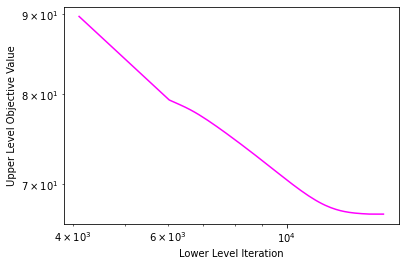

In [119]:
path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:5]

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,1]
#np.random.rand(np.shape(b)[0],np.shape(b)[1])
y = y[:,:,0:5]



Bilevel = HOAG(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
result = Bilevel.solver()
thetaOptimal = result
print("Theta:" +str(thetaOptimal))

print("objective: " + str(Bilevel.upperObjective[-1]))
plt.plot(Bilevel.lowerIter,Bilevel.upperObjective,color='magenta')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')

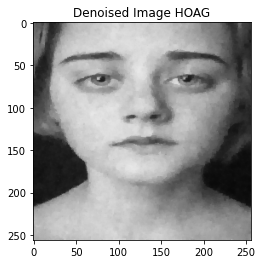

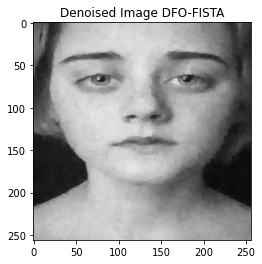

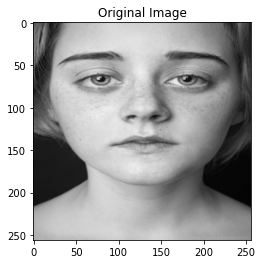

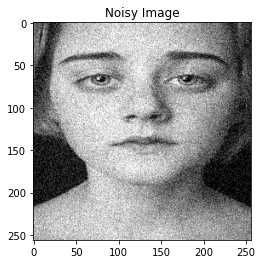

In [77]:
# Reconstruction HOAG
from PIL import Image
path = '/Users/sadegh/Downloads/Humans/256*256'
data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:50]
x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])
thetaOptimal2 = [-2.55845458, -5.06066663, -5.28944058]
#thetaOptimal2 = [-2.02649901, -4.7389812,  -9.06632174]

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
#x0 = y[:,:,3]
y = y[:,:,0:50]
Bilevel = HOAG(A, b, y, x0, 2, 1+1e-3, thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],max_iter=10000)
im = Bilevel.FISTA(thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],8,1e-10)*255
sample = im.reshape(256,256)
sample = Image.fromarray(sample)
plt.imshow(sample)
plt.title("Denoised Image HOAG")
plt.show()

Bilevel = HOAG(A, b, y, x0, 2, 1+1e-3, thetaOptimal2[0],  thetaOptimal2[1] ,  thetaOptimal2[2],max_iter=10000)
im = Bilevel.FISTA(thetaOptimal[0],  thetaOptimal[1] ,  thetaOptimal[2],8,1e-10)*255
sample = im.reshape(256,256)
sample = Image.fromarray(sample)
plt.imshow(sample)
plt.title("Denoised Image DFO-FISTA")
plt.show()

original = b[:,:,8]
original = original.reshape(256,256)*255
original = Image.fromarray(original)
plt.imshow(original)
plt.title("Original Image")
plt.show()

NImage = y[:,:,8]
NImage = NImage.reshape(256,256)*255
NImage = Image.fromarray(NImage)
plt.imshow(NImage)
plt.title("Noisy Image")
plt.show()

Initialise DFO
 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1    9.39e+01  7.09e+01  5.00e-01  5.00e-01    4   
  1     2    8.34e+01  2.43e+01  5.00e-01  5.00e-01    5   
  1     3    7.58e+01  1.92e+01  5.00e-01  5.00e-01    6   
  1     4    7.58e+01  1.16e+02  2.50e-01  5.00e-02    7   
  1     5    7.14e+01  1.32e+02  2.50e-01  5.00e-02    8   
  1     6    6.67e+01  2.55e+01  2.50e-01  5.00e-02    9   
  1     7    6.59e+01  4.87e+01  2.50e-01  5.00e-02   10   
  1     8    6.59e+01  3.06e+01  1.25e-01  5.00e-02   11   
  1     9    6.59e+01  1.54e+01  5.00e-02  5.00e-02   12   
  1    10    6.59e+01  2.41e+01  2.50e-02  5.00e-03   13   
  1    11    6.59e+01  5.29e+01  1.25e-02  5.00e-03   15   
  1    12    6.59e+01  1.56e+02  5.00e-03  5.00e-03   16   
  1    13    6.59e+01  3.01e+02  2.50e-03  5.00e-04   17   
  1    14    6.59e+01  4.06e+02  1.25e-03  5.00e-04   19   
  1    15    6.59e+01  1.93e+03  5.00e-04  5.00e-04   20   
  1    16    6.59e+01  2.

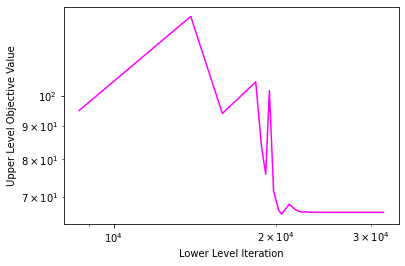

In [72]:
#2D TV
#Denoising
#Dynamic Accuracy
from functools import partial
from optparse import Option
from re import U
import numpy as np
import scipy.optimize as op
import dfols as dfo
from PIL import Image
import matplotlib.pyplot as plt

class DFO_FISTA:
    def __init__(self, A, b, y, x0, L, mu, alpha,nu, xi, max_iter=2000, tol=1e-1):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        self.x0 = np.zeros((np.shape(b)[2],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.L = L
        self.mu = mu
        self.nu = nu
        self.xi = xi
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.gtol = 0
        self.matsize = np.shape(x0)
        self.upperVal = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.upperEval = 0
        self.uppersolver = dfo.DFO()
    def FISTA(self, alpha,nu,xi,i):
        # Algorithm for solving the lower-level problem
        x = self.x0[i,:]
        t = 0
        if 10*self.uppersolver.delta**2 == 0:
            self.tol = 1e-1
        else:
            self.tol = 10*self.uppersolver.delta**2
        for k in range(self.max_iter):
            x_old = x
            x = np.reshape(x,(256,256))
            x = x.flatten()
            self.L = 1+ (np.exp(alpha)/np.exp(nu))* 8+np.exp(xi)
            self.mu = 1+np.exp(xi)
            tau = 1/(self.L)
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, alpha, nu, xi,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                self.lowerIterSum += k+1
                return self.x0[i,:]
            x = z -  tau*p

        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        return x

    def DFO(self):
        #theta0 = np.array([self.alpha, self.nu, self.xi])
        user_params = {'logging.save_diagnostic_info': True}
        user_params['logging.save_xk'] = True
        # Save diagnostic info to CSV
        soln = self.uppersolver.solve(self.UpperLevel, np.array([self.alpha, self.nu, self.xi]),bounds=(-10*np.ones(3),10*np.ones(3)),rhoend=1e-8,print_progress=True,maxfun=150,user_params=user_params)
        soln.diagnostic_info.to_csv('DFOdetail.csv')
        self.upperEval = self.uppersolver.evalCount
        return soln
    def phi(self, x, alpha,nu,xi, i):
        phi = 0.5*np.linalg.norm(x.flatten()-self.y[:,:,i].flatten())**2 +np.exp(alpha) * self.TV2D(x, np.exp(nu)) + 0.5 *np.exp(xi) * np.linalg.norm(x)**2
        return phi
    def TV(self,x, nu):
        return (np.sum(np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)))
    def TV2D(self,x, nu):
        x = np.reshape(x,(256,256))
        tv = 0
        tv += (np.sum(np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)))
        tv += (np.sum(np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)))
        return tv
    
    def gradTV2D(self,x, nu):

        x = np.reshape(x,(self.matsize[0],self.matsize[1]))

        grad = np.zeros(np.shape(x))
        grad[:,:-1]+= -(x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2)
        grad[:,1:] += (x[:,1:]-x[:,:-1])/np.sqrt(np.abs(x[:,1:]-x[:,:-1])**2+ nu**2) 
          
        grad[:-1,:]+= -(x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)
        grad[1:,:] += (x[1:,:]-x[:-1,:])/np.sqrt(np.abs(x[1:,:]-x[:-1,:])**2+ nu**2)             
        return grad.flatten()
    
    def gradTV(self,x, nu):
        grad = np.zeros(len(x))
        grad[:-1]+= -(x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        grad[1:] += (x[1:]-x[:-1])/np.sqrt(np.abs(x[1:]-x[:-1])**2+ nu**2)
        
        return np.squeeze(np.asarray(grad))
    def gradPhi(self, x, alpha,nu,xi,i):
        x = np.reshape(x,self.matsize)
        gradPhi = np.squeeze(np.asarray(x.flatten() - np.squeeze(np.asarray(self.y[:,:,i].flatten())) + np.exp(alpha) *self.gradTV2D(x, np.exp(nu)) + np.exp(xi) * x.flatten()))
        return gradPhi.flatten()
    
    def UpperLevel(self,theta):
        alpha = theta[0]
        nu = theta[1]
        xi = theta[2]
        # FISTA
        #The only successful iterations are commented
        # if self.uppersolver.funVal==0 or self.uppersolver.funVal==None:
        #     Usquared = [r**2 for r in UL]
        #     self.upperVal.append(np.sum(Usquared))
        #     self.lowerIter.append(self.lowerIterSum)
    
        
        # if self.uppersolver.funVal!=0:
        #     self.upperVal.append(self.uppersolver.funVal)
        #     self.lowerIter.append(self.lowerIterSum)
        UL = []
        for i in range(np.shape(self.b)[2]):
            UL.append(np.sqrt(1/np.shape(self.b)[2])*np.linalg.norm(self.FISTA(alpha,nu,xi,i)- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        # self.upperVal.append(np.sum(UL))
        # self.lowerIter.append(self.lowerIterSum)
        Usquared = [r**2 for r in UL]
        self.upperVal.append(np.sum(Usquared))
        self.lowerIter.append(self.lowerIterSum)
        #LBFGS
        # UL = []
        # for i in range(np.shape(self.b)[2]):
        #     UL.append(np.linalg.norm(self.LBFGS(alpha,nu,xi,i).flatten()- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        
        return np.squeeze(np.array([UL]))
    def LBFGS(self,alpha,nu,xi,i):
        x0 = self.x0.flatten()
        # op.fmin_l_bfgs_b(self.phi, self.gradPhi, x0=self.x0, args=(i,theta))
        self.x0 = op.minimize(self.phi, x0, args=(alpha,nu,xi,i), method='L-BFGS-B', jac=self.gradPhi,options={'disp': None, 'gtol': int(np.sqrt(len(x0)))*1e-06/(1+np.exp(xi))**2},tol= 1e-8).x
        self.gtol = 0
        return np.squeeze(np.asarray(self.x0))
    
    

path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:10]
#x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,1]
y = y[:,:,0:10]

Bilevel = DFO_FISTA(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
result = Bilevel.DFO()
thetaOptimal = result.x
print("Theta:" +str(thetaOptimal))

plt.plot(Bilevel.lowerIter,Bilevel.upperVal,color='magenta')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')
#[-2.62850676 -5.68326658 -4.82007257]



theta 1:  [-2.00308753 -4.96912472 -5.73177284]
g  87.54068009255333  g_old  100.67885774715
theta 2:  [-2.00533488 -4.94675549 -6.62633585]
g  87.00238424679193  g_old  87.54068009255333
theta 3:  [-2.00751768 -4.92510236 -7.38902768]
g  86.65765540461511  g_old  87.00238424679193
theta 4:  [-2.00971274 -4.90339926 -8.0970397 ]
g  86.3722452983747  g_old  86.65765540461511
theta 5:  [-2.01194309 -4.88142049 -8.77447379]
g  86.09954470643797  g_old  86.3722452983747
theta 6:  [-2.0142207  -4.85905169 -9.43050588]
g  85.82425733538034  g_old  86.09954470643797
theta 7:  [ -2.01655522  -4.8362033  -10.        ]
g  85.54060093769922  g_old  85.82425733538034
theta 8:  [ -2.01895529  -4.8127967  -10.        ]
g  85.23579672079072  g_old  85.54060093769922
theta 9:  [ -2.02142873  -4.78876268 -10.        ]
g  84.91445054388622  g_old  85.23579672079072
theta 10:  [ -2.02398406  -4.76402676 -10.        ]
g  84.57533689861957  g_old  84.91445054388622
theta 11:  [ -2.02662781  -4.73853491 -10

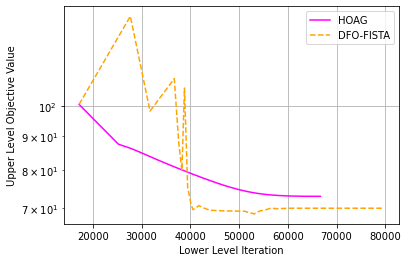

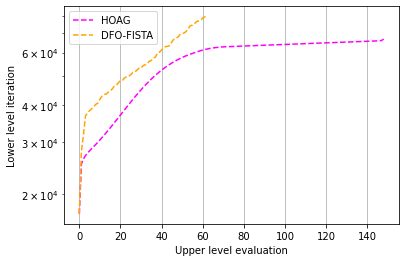

In [76]:
#Comparign DFO-FISTA with HOAG

path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:20]

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,4]
#np.random.rand(np.shape(b)[0],np.shape(b)[1])
y = y[:,:,0:20]



Bilevel1 = HOAG(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
result = Bilevel1.solver()

print("objective: " + str(Bilevel1.upperObjective[-1]))
plt.plot(Bilevel1.lowerIter,Bilevel1.upperObjective,color='magenta',label='HOAG')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
#plt.xscale('log')
plt.yscale('log')
plt.grid(True)
Bilevel2 = DFO_FISTA(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
result2 = Bilevel2.DFO()

plt.plot(Bilevel2.lowerIter,Bilevel2.upperVal,color='orange',label='DFO-FISTA',linestyle='--')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


#lower level iteration vs upper level iteration
plt.plot(np.linspace(0,len(Bilevel1.lowerIter),len(Bilevel1.lowerIter)),Bilevel1.lowerIter,color='magenta',label='HOAG',linestyle='--')
plt.plot(np.linspace(0,Bilevel2.upperEval,len(Bilevel2.lowerIter)),Bilevel2.lowerIter,color='orange',label='DFO-FISTA',linestyle='--')
plt.xlabel('Upper level evaluation')
plt.ylabel('Lower level iteration')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
#Convolutioal filters
#Denoising
#Dynamic Accuracy DFO-FISTA
from functools import partial
from optparse import Option
from re import U
import numpy as np
import scipy.optimize as op
import dfols as dfo
from PIL import Image
import matplotlib.pyplot as plt

class DFO_FISTA:
    def __init__(self, A, b, y, x0, L, mu, alpha,nu, xi, max_iter=2000, tol=1e-1):
        # A is the forward operator
        #b is the ground truth
        # y is the noisy image
        # x0 is the initial guess for low-level problem
        # L is the lipschitz constant
        # mu is the strong-convexity parameter
        # nu is the smoothing parameter for TV
        
        self.A = A
        self.b = b
        self.y = np.squeeze(np.asarray(y))
        self.x0 = np.zeros((np.shape(b)[2],len(x0.flatten())))
        self.x0[:,:] = x0.flatten()
        self.L = L
        self.mu = mu
        self.nu = nu
        self.xi = xi
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.gtol = 0
        self.matsize = np.shape(x0)
        self.upperVal = []
        self.lowerIter = []
        self.lowerIterSum = 0
        self.upperEval = 0
        self.uppersolver = dfo.DFO()
    def FISTA(self, alpha,nu,xi,i):
        # Algorithm for solving the lower-level problem
        x = self.x0[i,:]
        t = 0
        if 10*self.uppersolver.delta**2 == 0:
            self.tol = 1e-1
        else:
            self.tol = 10*self.uppersolver.delta**2
        for k in range(self.max_iter):
            x_old = x
            x = np.reshape(x,(256,256))
            x = x.flatten()
            self.L = 1+ (np.exp(alpha)/np.exp(nu))* 8+np.exp(xi)
            self.mu = 1+np.exp(xi)
            tau = 1/(self.L)
            q = tau*self.mu
            t_old = t
            t = (1-q*t**2+np.sqrt((1-q*t**2)**2+4*t**2))/2
            beta = ((t_old-1)*(1-t*q))/(t*(1-q))
            z = x + beta * (x-x_old)
            p = self.gradPhi(z, alpha, nu, xi,i)
            if np.linalg.norm(p)**2/self.mu**2 < self.tol:
                self.x0[i,:] = z -  tau*p
                self.lowerIterSum += k+1
                return self.x0[i,:]
            x = z -  tau*p

        self.x0[i,:] = x
        self.lowerIterSum += self.max_iter
        return x

    def DFO(self):
        #theta0 = np.array([self.alpha, self.nu, self.xi])
        user_params = {'logging.save_diagnostic_info': True}
        user_params['logging.save_xk'] = True
        # Save diagnostic info to CSV
        soln = self.uppersolver.solve(self.UpperLevel, np.array([self.alpha, self.nu, self.xi]),bounds=(-10*np.ones(3),10*np.ones(3)),rhoend=1e-8,print_progress=True,maxfun=150,user_params=user_params)
        soln.diagnostic_info.to_csv('DFOdetail.csv')
        self.upperEval = self.uppersolver.evalCount
        return soln
    def phi(self, x, alpha,nu,xi, i):
        phi = 0.5*np.linalg.norm(x.flatten()-self.y[:,:,i].flatten())**2 +np.exp(alpha) * self.TV2D(x, np.exp(nu)) + 0.5 *np.exp(xi) * np.linalg.norm(x)**2
        return phi
    def gradPhi(self, x, alpha,nu,xi,i):
        x = np.reshape(x,self.matsize)
        gradPhi = np.squeeze(np.asarray(x.flatten() - np.squeeze(np.asarray(self.y[:,:,i].flatten())) + np.exp(alpha) *self.gradTV2D(x, np.exp(nu)) + np.exp(xi) * x.flatten()))
        return gradPhi.flatten()
    
    def UpperLevel(self,theta):
        alpha = theta[0]
        nu = theta[1]
        xi = theta[2]
        # FISTA
        UL = []
        for i in range(np.shape(self.b)[2]):
            UL.append(np.sqrt(1/np.shape(self.b)[2])*np.linalg.norm(self.FISTA(alpha,nu,xi,i)- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        # self.upperVal.append(np.sum(UL))
        # self.lowerIter.append(self.lowerIterSum)
        Usquared = [r**2 for r in UL]
        self.upperVal.append(np.sum(Usquared))
        self.lowerIter.append(self.lowerIterSum)
        #LBFGS
        # UL = []
        # for i in range(np.shape(self.b)[2]):
        #     UL.append(np.linalg.norm(self.LBFGS(alpha,nu,xi,i).flatten()- np.squeeze(np.asarray(self.b[:,:,i].flatten()))))
        
        return np.squeeze(np.array([UL]))
    def LBFGS(self,alpha,nu,xi,i):
        x0 = self.x0.flatten()
        # op.fmin_l_bfgs_b(self.phi, self.gradPhi, x0=self.x0, args=(i,theta))
        self.x0 = op.minimize(self.phi, x0, args=(alpha,nu,xi,i), method='L-BFGS-B', jac=self.gradPhi,options={'disp': None, 'gtol': int(np.sqrt(len(x0)))*1e-06/(1+np.exp(xi))**2},tol= 1e-8).x
        self.gtol = 0
        return np.squeeze(np.asarray(self.x0))
    
    

path = '/Users/sadegh/Downloads/Humans/256*256'

#np.random.seed(0)

data = np.load(path+ '/' +'Data.npz')
b = data['X']
b = b/255
b = b[:,:,0:10]
#x0 = np.random.rand(np.shape(b)[0],np.shape(b)[1])

A = np.eye(b.shape[1])
NoisyData = np.load(path+ '/' +'DataNoisy2.npz')
y = NoisyData['y']
y = y/255
x0 = y[:,:,1]
y = y[:,:,0:10]

Bilevel = DFO_FISTA(A, b, y, x0, 0.1, 1.2, -2,-5,-4)
result = Bilevel.DFO()
thetaOptimal = result.x
print("Theta:" +str(thetaOptimal))

plt.plot(Bilevel.lowerIter,Bilevel.upperVal,color='magenta')
plt.xlabel('Lower Level Iteration')
plt.ylabel('Upper Level Objective Value')
plt.xscale('log')
plt.yscale('log')
#[-2.62850676 -5.68326658 -4.82007257]

